# 7  | Lab session | Team coding: Swept-plane Scanner Camera Calibration

**ES143 Computer Vision, Harvard University**

**Due at the end of lab session (Mar. 21 & Mar. 22)**

Names: *(<font color=red>Ashley Redhead</font>)*

Team planning document: *(<font color=red>https://docs.google.com/document/d/1W5ZUlYgBokWF8KO6M3fw_CpQtWzNPjKqVJNaJwPI98w/edit</font>)*

<br>

---

*When you are done solving this assignment, submit your `.ipynb` and `.html` files to the appropriate assignment on Canvas. Instructions for generating and naming the files are [at the bottom of this notebook](#submission).*

---

In this team coding task you will:
* Capture a calibration video of your "AprilBoard" fiducial board
* Calibrate your camera using keyframes extracted from this video
* Complete and submit a Team Plan google document for the Swept-plane Scanner project

To maximize your learning, you and your teamate(s) must each create and submit your own notebooks. However, this task is an open collaboration between you and your teamate(s), so it is encouraged for you to work together, for example by dividing up tasks, sharing snippets of code with each other, and helping each other with strategy and debugging.

As usual, use of generative AI tools must adhere to the course policy as described in the [ES 143 Syllabus](https://canvas.harvard.edu/courses/129415/assignments/syllabus). In particular:
* You may not submit AI-generated code that you cannot explain, or whose validity and correctness you have not verified.
* Your use of generative AI tools must be documented in [this text cell](#ai-disclosure) at the bottom of the notebook.

Small items marked with "<font color='red'>**To Do**</font>" require you to act and think but will not be evaluated. Sections marked with "<font color='red'>**TASK ##**</font>" will be evaluated.

### Getting started

If you have not already done so, begin by creating a copy of the notebook in your google drive. The filepath for this assignment should be

`My Drive/es-143-assignments/L07/7_Scanner_Calibration.ipynb`

Additionally, create a `data` subfolder in your google drive at
`My Drive/es-143-assignments/L07/data/`
that you can use when you upload your captured video file and to store extracted frames from it. (The video file and extracted frames will not be submitted.)

### When you are done

1. Enter the URL of your completed Team Plan google document in the field above
2. Have each team member submit their `.html` and `.ipynb` in Canvas. Filenames should be of the form
`LASTNAME1_LASTNAME2_L07-Scanner_Calibration.{html,ipynb}`.


# Setup

In [1]:
# Mount your google drive. This will launch a pop-up window for authentication.

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# YOU SHOULD HAVE ALREADY COPIED THE ASSIGNMENT FILES TO THIS
# FOLDER ON YOUR GOOGLE DRIVE

#cd your_path_here
# %cd "/content/drive/My Drive/es-143-assignments/3D-Scanner/"

In [3]:
# Install pupil_apriltags package. This a wrapper for the Apriltags3 library developed by AprilRobotics.
# Documentation at https://github.com/pupil-labs/apriltags

# %pip install pupil-apriltags

In [4]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [5]:
# Fetch lists of target-IDs and 2D target locations (in inches) corresponding to the two
#   printed April boards.
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [6]:
#@title Helper function: `detect_aprilboard()`
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    """
    Detects April tags in a grayscale image.

    Usage: imgpoints, objpoints, tag_ids = detect_aprilboard(img, board, AT_detector)

    Input:
        image -- grayscale image
        board -- at_coarseboard or at_fineboard (list of dictionaries)
        AT_detector -- AprilTag Detector parameters

    Returns:
        imgpoints -- Nx2 numpy array of (x,y) image coords
        objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
        tag_ids -- Nx1 list of tag IDs
    """

    imgpoints=[]
    objpoints=[]
    tagIDs=[]

    # detect april tags
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))

        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))

            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])

            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))

            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

# <font color='red'>**TASK 1**</font>. Capture calibration video

Here you will practice acquiring calibration data in video mode on your smartphone. We do this in video mode instead of photo mode because the intrinsic parameters vary between the two modes, and because video mode will be required when capturing shadow datasets.

Follow this capture protocol to acquire a calibration video:
1. Place the `fine` AprilBoard on a flat, uncluttered surface.
  * Either board can be used in general, but for today's lab it is important that you use the `fine` board, meaning the one with the $8\times 10$ grid of smaller fiducals.
2. Launch the built-in Apple camera app on your iPhone
2. Click `Video` to place your camera in video mode
3. Aim your camera at the AprilBoard so that it fills roughly half of the frame's area, and focus your camera by tapping on your smartphone's screen, roughly in the middle of the board. Now tap and hold there until you see `AE/AF lock` appear at the top of the app.
  * This "focus locking" step prevents the camera's autofocus system from changing the instrinsic parameters during capture, and when capturing data from your swept-plane scanner, you will want to make sure the focus remains locked and the same across the calibration video as as well as all of the associated shadow video(s).)
4. Tap the red shutter button to begin recording. Move your camera to between 10 and 20 different viewpoints around the AprilBoard that are roughly uniformly spaced on the hemisphere above it. Tap the shutter button again to stop recording. Follow these tips:
  * Move your camera quickly between viewpoints, and pause at each viewpoint for 0.5s or so, holding your camera as still as possible during that pause. (The frames that are captured during your quick motions will have motion blur, and they will be automatically discarded in subsequent processing.)
  * Pause at viewpoints that are roughly the same distance from the Aprilboard. This avoids inducing unwanted defocus blur through depth-of-field effects.
  * When pausing at each viewpoint, frame the board so that all of the fiducials are contained entirely within the frame.
  * Frame the AprilBoard across viewpoints in ways that provide "spatial variety", with the board being variously framed nearer to the top, bottom, left, right and corners of the pixel array. The idea is that, in aggregate, you want your observed fiducials to cover as much of the spatial $H\times W$ pixel array as possible.

Review your video, and re-capture if necessary. This will take a few attempts to get right. When you are satisfied with your video, upload the video file to  `My Drive/es-143-assignments/L07/data/` on your google drive.


# <font color='red'>**TASK 2**</font>. Extract keyframes from calibration video

In most video formats (e.g., .mp4, .mov), some frames are treated as “keyframes” (a.k.a. I-frames) that are compressed and encoded using the pixel values at that single moment in time (like a still image), while other frames are compressed and encoded using differences from, and interpolations between, these keyframes.

The following cell uses the `ffmpeg` library to extract only keyframes (I-frames), which are often less effected by motion and compression artifacts.

Also, most video formats encode luminance and chrominance separately (using a luminance/chrominance color space instead of RGB), so the following cell also uses `ffmpeg` to extract only the luminance channel of the extracted keyframes. This produces a set of grayscale images that are sufficient for the purposes of calibration.

The cell writes the extracted frames to PNG files on your google drive using filepaths

`My Drive/es-143-assignments/L07/data/out_keyframes_####.png`

<font color='red'>**To Do**</font>: Edit the video filename in the following cell to match your uploaded video, and then run the cell to extract a set of grayscale calibration keyframes. Then run the second cell a few times with different filenames to visualize some of the extract frames.

In [7]:
#@title extract keyframes
!ffmpeg -i ./data/calibration.MOV -vf "select='eq(pict_type,I)', extractplanes=y" -pix_fmt gray -vsync vfr -q:v 2 ./data/calibration/out_keyframes_%04d.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

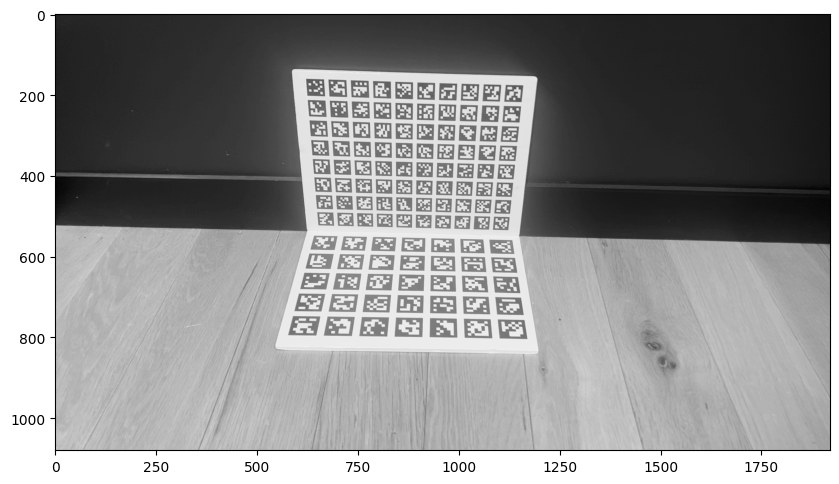

In [8]:
#@title visualize a keyframe

# edit the filepath to see different keyframes
img = plt.imread('./data/shadow/out_keyframes_0003.png')
plt.imshow(img, cmap = 'gray')

# <font color='red'>**TASK 3**</font>. Detect fiducials and calibrate camera

The following cell is a nearly identical copy of the code from 7 Pre-session A (CalibrateCamera). But to ensure accurate results, we modify the code to only accept images that have more than $N=70$ detections (of the maximum possible 80 that exist on the fine AprilBoard).

<font color='red'>**To Do**</font>:
1. Run the first cell to detect fiducials in your extracted keyframes and discard the ones with $N<70$ detections.
  * Verify that the cell's output contains visualizations at least ~15 frames with successful detections. If it does not, look for a bug, talk to your TF, or capture another video and try again.
2. Run the second cell to calibrate your camera. Examine the output to verify that the reprojection error and camera matrix are reasonable.

In [9]:
#@title detect fiducials

N = 70 # only use images with at least N detected objects for calibration
total_valid = 0

# Edit this line to point to the collection of input calibration image
CALIBFILES = './data/out_keyframes_*.png'

# Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
BOARD = at_fineboard
#BOARD = at_coarseboard

###### BEGIN CALIBRATION SCRIPT

# exit if no images are found or if BOARD is unrecognized
images = glob.glob(CALIBFILES)
assert images, "no calibration images matching: " + CALIBFILES
assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

# else continue
print("{} images:".format(len(images)))

# initialize 3D object points and 2D image points
calObjPoints = []
calImgPoints = []

# define the number of columns for the plot, then calculate number of rows
num_plot_cols = 5
num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols

# create the figure and axes; flatten the axes array for convenvience
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
axs = axs.flatten()

# loop through the images
for count,fname in enumerate(images):

    # read image and convert to grayscale if necessary
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig

    # show image
    axs[count].imshow(img / 255.0, cmap="gray")
    axs[count].set_axis_off()
    axs[count].set_title("Image {}".format(count))

    # detect apriltags and report number of detections
    imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
    #print("{} {}: {} imgpts, {} objpts".format(count, fname, len(imgpoints),len(objpoints)))
    print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

    # append detections if some are found
    if len(imgpoints) >= N and len(objpoints) >= N:
        total_valid += 1
        # display detected tag centers
        axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')

        # append points detected in all images, (there is only one image now)
        calObjPoints.append(objpoints.astype('float32'))
        calImgPoints.append(imgpoints.astype('float32'))

plt.show()

AssertionError: no calibration images matching: ./data/out_keyframes_*.png

In [ ]:
#@title calibrate camera

# calibrate the camera
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPoints,
    calImgPoints,
    img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
    None,         # no initial guess for the remaining entries of calMatrix
    None,         # initial guesses for distortion coefficients are all 0
    flags = None) # default contstraints (see documentation)

# Print output, including reprojection error, which is the root mean square (RMS)
#   re-projection error in pixels. If this value is much greater than 1, it is
#   likely to be a bad calibration.  Examine the images and detections, and the
#   options given to cv2.calibrateCamera() to figure out what went wrong.
np.set_printoptions(precision=5, suppress=True)
print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)

np.set_printoptions(precision=2, suppress=True)
print('Intrinsic camera matrix:\n', calMatrix)
print('Total images used for calibration: ', total_valid)


RMSE of reprojected points: 0.18066302372728335
Distortion coefficients: [[ 0.22731 -1.55169 -0.00194 -0.00024  3.50686]]
Intrinsic camera matrix:
 [[1673.72    0.    959.  ]
 [   0.   1672.34  532.32]
 [   0.      0.      1.  ]]
Total images used for calibration:  30


# <font color='red'>**TASK 4**</font>. Error evaluation and Visualization

A bad calibration can have negative effects on downstream applications, and these effects can be hard to debug. So in general, one should aim to be as confident as possible about one's calibration. One way to do this is to compute and display the average reprojection error for each image, which provides more detail that the overall reprojection error provided by openCV.

Run the following cells to compute and display the per-image reprojection errors, and to display the reprojected points on any one of the images of your choosing. You should expect reprojection errors that are half a pixel or less.

In [ ]:
#@title Compute reprojection error separately in each image

# initial array for storing per-image reprojection errors
mean_errors=[]

# project 3D board points into the images, and compute the per-image reprojection error
for i in range(len(calObjPoints)):
    imgpoints2, _ = cv2.projectPoints(calObjPoints[i], calRotations[i], calTranslations[i], calMatrix, distCoeffs)
    mean_errors.append(np.mean(np.linalg.norm(calImgPoints[i] - np.squeeze(imgpoints2),axis=1)))

print("Per-image reprojection errors:")

# Print the list of per-image reprojection errors with at most 5 elements per line
print('\n'.join([', '.join([f"{error:.{5}f}" for error in mean_errors[i:i+5]]) for i in range(0, len(mean_errors), 5)]))


Per-image reprojection errors:
0.08851, 0.13161, 0.12630, 0.12764, 0.12422
0.08753, 0.12131, 0.15788, 0.15216, 0.17777
0.16548, 0.19074, 0.17881, 0.14956, 0.19308
0.18717, 0.13950, 0.12563, 0.12022, 0.16092
0.16680, 0.19156, 0.16694, 0.20066, 0.20406
0.17961, 0.15020, 0.13308, 0.16575, 0.11090


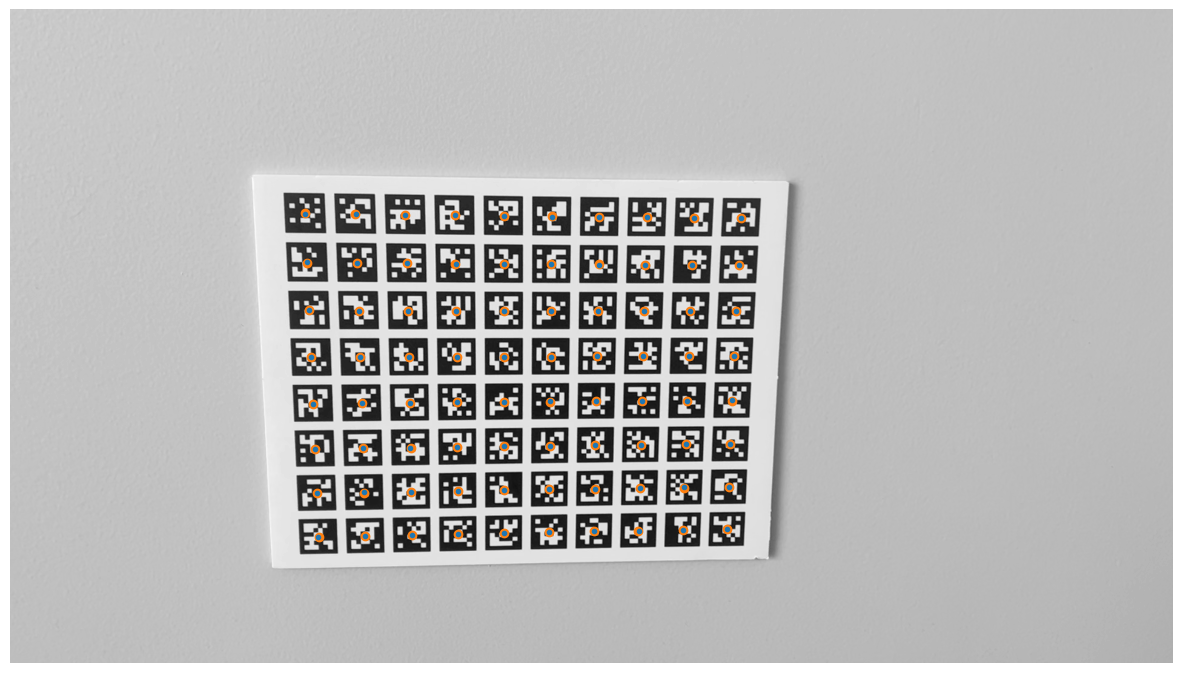

In [ ]:
#@title Display the projected points in one of the images

# change this to select which calibration image to display
IMNUM=1

# read image and convert to grayscale if necessary
orig = cv2.imread(images[IMNUM])
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig

# create figure, show image
fig,ax =plt.subplots(figsize=(15,15))
ax.imshow(img / 255.0, cmap="gray")
ax.set_axis_off()

# show detected points (in orange)
ax.scatter(calImgPoints[IMNUM][:,0], calImgPoints[IMNUM][:,1], marker='o', color='#ff7f0e')

# compute reprojections
imgpoints2, _ = cv2.projectPoints(calObjPoints[IMNUM],
                                  calRotations[IMNUM],
                                  calTranslations[IMNUM],
                                  calMatrix, distCoeffs)
imgpoints2=np.squeeze(imgpoints2) # eliminate the leading single dimension

# show reprojected points (in blue)
ax.scatter(imgpoints2[:,0], imgpoints2[:,1], marker='.', color='#1f77b4')

<a name="submission"></a>
# Submission

The following cells generate an HTML version of your notebook in the `./submit` directory associated with this assignment on your google drive. Once it is generated, submit your `.html` and `.ipynb` files to the appropriate assignment on Canvas using filenames

 `LASTNAME1_LASTNAME2_L07-Scanner_Calibration.{html,ipynb}`

**Important**: Remember to edit the filenames (either in the cells below or on your local computer after downloading) to match your name, and make sure that all cells execute properly (i.e., click Runtime -> Restart session and run all) before exporting to HTML.

In [ ]:
!mkdir "submit"

In [ ]:
# Convert to HTML. Before running this cell:
# 1. edit your name in this cell
# 2. make sure your notebook executes and is saved

!jupyter nbconvert --to html 7_Scanner_Calibration.ipynb --output-dir "submit" --output "Redhead_Sedik_Fidalgo_L07_Scanner_Calibration.html"

[NbConvertApp] Converting notebook 7_Scanner_Calibration.ipynb to html
[NbConvertApp] Writing 1909945 bytes to submit/Redhead_Sedik_Fidalgo_L07_Scanner_Calibration.html
